**Avant de débuter ce TP** :

1. **Changez le type d'exécution sur Google Colab** : `Exécution > Modifiez le type d'exécution > T4 GPU`
2. **Installez les paquets ci-dessous** :

In [ ]:
! pip install lightning torchmetrics torchinfo

3. Exécutez ce code pour supprimer quelques messages et avertissements éventuellement affichés.

In [1]:
import logging
logging.getLogger("lightning").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)
logger = logging.getLogger("lightning")
logger.propagate = False

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*Missing logger folder.*")

# Synthèse d'images par résonance magnétique cérébrales

## Introduction

L'imagerie par résonance magnétique (IRM) est une technique d'imagerie médicale permettant d'obtenir des vues en deux ou en trois dimensions de l'intérieur du corps de façon non invasive avec une résolution en contraste relativement élevée ([Wikipedia](https://fr.wikipedia.org/wiki/Imagerie_par_résonance_magnétique)).

Il existe différents types d'images par résonance magnétique, appelées pondérations.
De manière simplifiée, en modifiant les paramètres d'acquisition, on obtient des images différentes mettant en avant des caractéristiques différentes.

Parmi les pondérations existantes, deux sont couramment utilisées :

* La **pondération T1** met en avant les régions avec de la graisse, notamment les [tissus adipeux](https://fr.wikipedia.org/wiki/Tissu_adipeux), et donc les régions cervicales contenant beaucoup de tissus adipeux.
* La **pondération T2** met en avant les liquides, notamment le [liquide cérébrospinal](https://fr.wikipedia.org/wiki/Liquide_cérébrospinal), et donc les régions cervicales contenant beaucoup de iquide cérébrospinal.

Les images cérébrales complètes sont des images en trois dimensions.
Néanmoins, la visualisation est plus facile pour l'oeil humain en deux dimensions.
On utilise donc en général des coupes en deux dimensions.
L'image en trois dimensions étant un parallélépipède rectangle, il existe trois manières de couper une image en trois dimensions, chacune associé à un axe dont la valeur est fixe.

[<img src="../figures/coupes_irm.png" width="750" />](../figures/coupes_irm.png)

L'image ci-dessus illustre ces trois type de coupe : une coupe axiale (à gauche), une coupe coronnale (au milieu) et une coupe sagittale (à droite).
La coupe axiale étant celle qui permet de couvrir le mieux le cerveau, c'est la coupe généralement utilisée.

L'image ci-dessous illustre deux coupes axiales, avec une pondération T1 à gauche et une pondération T2 à droite.

[<img src="../figures/brain_mri_t1_t2.png" width="500" />](../figures/brain_mri_t1_t2.png)

**L'objectif de ce notebook est de prédire l'image T2 à partir de l'image T1**.
L'intérêt pratique de cette approche est est de réduire l'utilisation des machines IRM : une seule acquisition serait nécessaire pour obtenir les pondérations.


## (Télé)chargement du jeu de données

Nous allons travailler sur un jeu de données public appelé [IXI dataset](http://brain-development.org/ixi-dataset/).
Les données prétraitées sont disponibles sur ce [dépôt GitHub](https://github.com/Easternwen/IXI-dataset).
Dans le dossier `size64`, il y a $1154$ fichiers, correspondant à $2$ images pour chacun des $577$ sujets.
La taille de chaque image est $(64, 64)$.

La commande suivante permet de cloner le dépôt GitHub dans le dossier `data` nouvellement créé.

In [2]:
! mkdir data && cd data && git clone https://github.com/Easternwen/IXI-dataset

mkdir: data: File exists


Visualions quelques images du jeu de données grâce à la fonction `plot_images_one_subject()` définie ci-dessous.

In [3]:
import matplotlib.pyplot as plt
import os
import torch


def plot_images_one_subject(idx=None):
    """Affiche les coupes T1 et T2 d'un sujet.
    
    Parameters
    ----------
    idx : int (default = None)
        Indice du sujet. La liste des indices valides est disponible
        dans la variable `idx_valid` définie ci-dessous. Si l'indice
        n'est pas valide, un indice est tiré aléatoirement parmi la
        liste d'indices valides.
    """
    idx_valid = [
         2,  12,  13,  14,  15,  16,  17,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119,
       120, 121, 122, 123, 126, 127, 128, 129, 130, 131, 132, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 150,
       151, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 183, 184, 185, 186, 188, 189, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209,
       210, 211, 212, 213, 214, 216, 217, 218, 219, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 236, 237, 238,
       239, 240, 241, 242, 244, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 270, 274, 275, 276, 277, 278, 279, 280, 282, 284,
       285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297,
       298, 299, 300, 302, 303, 304, 305, 306, 307, 308, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 324, 325, 326,
       327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 340,
       341, 342, 344, 345, 347, 348, 350, 351, 353, 354, 356, 357, 358,
       359, 360, 361, 362, 363, 364, 365, 367, 368, 369, 370, 371, 372,
       373, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386,
       387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399,
       400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412,
       413, 414, 415, 416, 417, 418, 419, 420, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       467, 468, 469, 470, 473, 474, 475, 476, 477, 478, 479, 480, 481,
       482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
       495, 496, 497, 498, 499, 501, 502, 503, 504, 505, 506, 507, 508,
       510, 511, 512, 515, 516, 517, 518, 519, 521, 522, 523, 524, 525,
       526, 527, 528, 531, 532, 533, 534, 535, 536, 537, 538, 539, 541,
       542, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555,
       556, 558, 559, 560, 561, 562, 563, 565, 566, 567, 568, 569, 571,
       572, 573, 574, 575, 576, 577, 578, 579, 582, 584, 585, 586, 587,
       588, 589, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601,
       603, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 616, 617,
       618, 619, 621, 622, 623, 625, 626, 627, 629, 630, 631, 632, 633,
       634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 646, 648,
       651, 652, 653, 661, 662
    ]

    if not (isinstance(idx, int) and idx in idx_valid):
        import random
        idx = random.choice(idx_valid)

    plt.figure(figsize=(9, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(
        torch.transpose(
            torch.load(
                os.path.join(
                    'data', 'IXI-dataset', 'size64', f'sub-IXI{idx:03} - T1.pt'
                ), weights_only=True
            ), 0, 1
        ), cmap='gray', origin='lower'
    )
    plt.title(f"Coupe T1 pour le sujet {idx:03}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(
        torch.transpose(
            torch.load(
                os.path.join(
                    'data', 'IXI-dataset', 'size64', f'sub-IXI{idx:03} - T2.pt'
                ), weights_only=True
            ), 0, 1), 
        cmap='gray', origin='lower'
    )
    plt.title(f"Coupe T2 pour le sujet {idx:03}")
    plt.axis('off')
    plt.show()

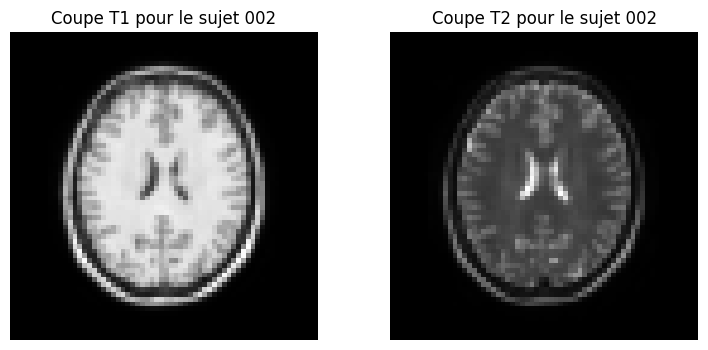

In [4]:
plot_images_one_subject(2)

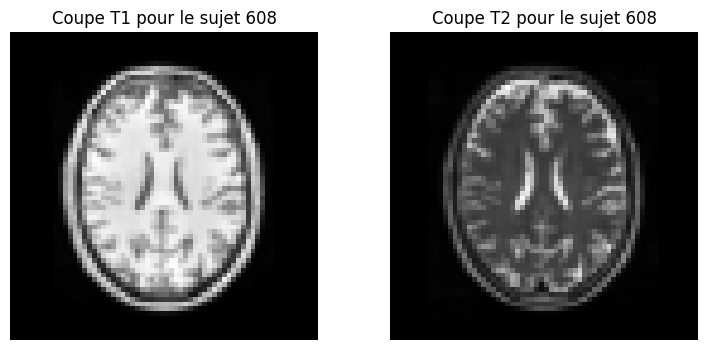

In [5]:
plot_images_one_subject(608)

On va maintenant définir notre propre classe pour ce jeu de données.
80% du jeu de données est utilisé pour le jeu d'entraînement, 20% pour le jeu de validation.
La classe `CustomDataset()` définie ci-dessous permet de créer ces deux jeux de données.
On l'utilise pour créer les *dataloaders* pour les jeux d'entraînement et de validation avec des lots de taille $32$.

In [6]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    """Classe relative au jeu de données IXI.

    Parameters
    ----------
    mode : {'training', 'validation'}
        Partie du jeu de données.

    """
    def __init__(self, mode="training"):
        
        root = os.path.join('data', 'IXI-dataset', 'size64')

        files = sorted(os.listdir(root))
        patient_id = list(set([i.split()[0] for i in files]))
        split_idx = int(0.8 * len(patient_id))
        imgs = []

        if mode == "training":
            for i in patient_id[:split_idx]:
                if (
                    os.path.isfile(os.path.join(root, f"{i} - T1.pt")) and
                    os.path.isfile(os.path.join(root, f"{i} - T2.pt"))
                ):
                    imgs.append((os.path.join(root, f"{i} - T1.pt"),
                                 os.path.join(root, f"{i} - T2.pt")))
        elif mode == "validation":
            for i in patient_id[split_idx:]:
                if (
                    os.path.isfile(os.path.join(root, f"{i} - T1.pt")) and
                    os.path.isfile(os.path.join(root, f"{i} - T2.pt"))
                ):
                    imgs.append((os.path.join(root, f"{i} - T1.pt"),
                                 os.path.join(root, f"{i} - T2.pt")))
        else:
            raise ValueError("'mode' doit être l'un de 'training' ou 'validation'.")

        self.imgs = imgs

    def __getitem__(self, index):
        t1_path, t2_path = self.imgs[index]
        
        # Ajoute une dimension supplémentaire pour les canaux
        t1 = torch.unsqueeze(torch.load(t1_path, weights_only=True), 0).to(dtype=torch.float32)
        t2 = torch.unsqueeze(torch.load(t2_path, weights_only=True), 0).to(dtype=torch.float32)

        return t1, t2

    def __len__(self):
        return len(self.imgs)
    

# Datasets
dataset_train = CustomDataset(mode="training")
dataset_val = CustomDataset(mode="validation")

# Dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=32)

On vérifie la taille des images en entrée et en sortie.
On n'affiche ici les tailles que pour la première observation du jeu d'entraînement, mais on admettra que ces informations sont valables pour toutes les observations (c'est bien le cas).

In [7]:
print(f"Taille d'une image T1 : {dataset_train[0][0].size()}")
print(f"Taille d'une image T2 : {dataset_train[0][1].size()}")

Taille d'une image T1 : torch.Size([1, 64, 64])
Taille d'une image T2 : torch.Size([1, 64, 64])


## Générateur

Dans cette section, on va entraîner un générateur pour générer l'image T2 à partir de l'image T1.
Cela est rendu possible du fait que le jeu de données est apparié : on a accès aux images T1 et T2 du même sujet. 

### Question 1

Complétez les méthodes `__init__()` et `forward()` de la classe `Generator()` définie ci-dessous en utilisant les informations fournies dans le texte ci-dessous.

#### Architecture

Notre générateur aura une architecture de type **U-Net** avec les caractéristiques suivantes :

* Les blocs descendants sont constitués d'une couche de convolution, puis d'une couche de normalisation et enfin la fonction d'activation ReLU.

* Les blocs ascendants sont constitués d'une couche de convolution transposée, puis d'une couche de normalisation et enfin la fonction d'activation ReLU.

L'architecture exacte, avec les valeurs des hyperparamètres pour chacune des couches, est représentée par l'image ci-dessous.
Si une couche prend deux cartes de caractéristiques en entrée, celles-ci sont concaténées (sur la dimension des canaux).
Le code pour les classes correspondant aux différents blocs vous sont déjà fournies ci-dessous : `UNetDown()`, `UNetUP()` et `FinalBloc()` correspondent aux blocs descendants, blocs ascendants et bloc final respectivement.

[<img src="../figures/generator.png" width="750" />](../figures/generator.png)

#### Entraînement

Le modèle sera entraîné en utilisant l'erreur absolue moyenne comme fonction de perte.
Vous pouvez utiliser [torch.nn.L1Loss()](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html).

#### Métriques d'évaluation

La performance d'un modèle sera évaluée avec la similarité structurelle (SSIM pour [*structural similarity index measure*](https://en.wikipedia.org/wiki/Structural_similarity_index_measure)).
Des explications concernant cette métrique seront fournies plus tard dans ce notebook.
Pour l'instant, tout ce dont avait besoin de savoir est qu'il s'agit d'un score compris entre $0$ (le moins bon) et $1$ (le meilleur) et qu'elle est déjà implémentée dans le paquet `torchmetrics` : [`torchmetrics.image.StructuralSimilarityIndexMeasure()`](https://lightning.ai/docs/torchmetrics/stable/image/structural_similarity.html).

In [8]:
class UNetDown(torch.nn.Module):
    """Bloc descendant de notre U-Net.

    Parameters
    ----------
    in_channels : int
        Nombre de canaux dans l'image en entrée.
        
    out_channels : int
        Nombre de canaux dans l'image en sortie.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            torch.nn.InstanceNorm2d(out_channels),
            torch.nn.ReLU()
          )

    def forward(self, x):
        return self.model(x)


class UNetUp(torch.nn.Module):
    """Bloc ascendant de notre U-Net.

    Parameters
    ----------
    in_channels : int
        Nombre de canaux dans l'image en entrée.
        
    out_channels : int
        Nombre de canaux dans l'image en sortie.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size=4, stride=2, padding=1
            ),
            torch.nn.InstanceNorm2d(out_channels),
            torch.nn.ReLU()
        )

    def forward(self, x, skip_input=None):
        if skip_input is not None:
            dim = 0 if x.ndim == 3 else 1
            x = torch.cat((x, skip_input), dim)  # add the skip connection
        return self.model(x)


class FinalBloc(torch.nn.Module):
    """Bloc final de notre the U-Net.

    Parameters
    ----------
    in_channels : int
        Nombre de canaux dans l'image en entrée.
        
    out_channels : int
        Nombre de canaux dans l'image en sortie.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.Tanh(),
        )

    def forward(self, x, skip_input=None):
        if skip_input is not None:
            dim = 0 if x.ndim == 3 else 1
            x = torch.cat((x, skip_input), dim)  # add the skip connection
        return self.model(x)

In [9]:
import lightning as L
from torchmetrics.image import StructuralSimilarityIndexMeasure


class Generator(L.LightningModule):
    """Classe pour le générateur.
    
    Parameters
    ----------
    in_channels : int (default = 1)
        Nombre de canaux dans l'image en entrée.

    out_channels : int (default = 1)
        Nombre de canaux dans l'image renvoyée en sortie.

    lr : float (default = 1e-3)
        Taux d'apprentissage.

    betas : tuple[float, float] (default = (0.9, 0.999))
        Paramètres betas de l'algorithme d'optimisation Adam.
    """
    def __init__(self, in_channels=1, out_channels=1, lr=1e-3, betas=(0.9, 0.999)):
        super().__init__()

        self.lr = lr
        self.betas = betas

        ### BEGIN TODO ###
        # Intialisation des blocs de l'architecture
        self.down1 = UNetDown(in_channels, 64)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512)
        self.down5 = UNetDown(512, 512)

        self.up1 = UNetUp(512, 512)
        self.up2 = UNetUp(1024, 256)
        self.up3 = UNetUp(512, 128)
        self.up4 = UNetUp(256, 64)

        self.final = FinalBloc(128, out_channels)
        
        # Initialisation de la fonction de perte
        self.loss = torch.nn.L1Loss()
        
        # Initialisation des métriques
        self.ssim_train = StructuralSimilarityIndexMeasure(data_range=(-1.0, 1.0))
        self.ssim_val = StructuralSimilarityIndexMeasure(data_range=(-1.0, 1.0))
        #### END TODO ####

    def forward(self, x):
        ### BEGIN TODO ###
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        u1 = self.up1(d5)
        u2 = self.up2(u1, d4)
        u3 = self.up3(u2, d3)
        u4 = self.up4(u3, d2)
        y = self.final(u4, d1)
        #### END TODO ####
        return y
    
    def step(self, batch, dataset):
        """Effectue une étape.

        Une étape consiste à passer d'un lot d'observations (l'argument batch)
        à l'évaluation de la fonction de coût pour ce lot d'observations.

        Parameters
        ----------
        batch : tuple
            Un lot d'observations. Le premier élément du tuple est le lot
            des entrées, le second est le lot des labels.
            
        dataset : {"training", "validation"}
            Jeu de données utilisé.

        Returns
        -------
        loss : Tensor, shape = (1,)
            La fonction de coût pour ce lot d'observations.
        """
        X, Y = batch 
        Y_pred = self(X)
        loss = self.loss(Y_pred, Y)

        if dataset == "training":
            metric = self.ssim_train
            name = "train"
            bar_step = True
        else:
            metric = self.ssim_val
            name = "val"
            bar_step = False

        ssim = metric(Y_pred, Y)
        self.log(f"loss_{name}", loss, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        self.log(f"ssim_{name}", ssim, prog_bar=bar_step, on_step=bar_step, on_epoch=True)

        return loss
    
    def training_step(self, batch):
        return self.step(batch, "training")
    
    def validation_step(self, batch):
        return self.step(batch, "validation")
    
    def on_train_start(self):
        """Code exécuté au début de l'entraînement."""
        string = f"Version {self.trainer.logger.version}"
        print(f"{string}\n{'=' * len(string)}\n")
    
    def on_train_epoch_end(self):
        """Code exécuté à la fin de chaque époque d'entraînement."""
        metrics = self.trainer.callback_metrics
        string = (f"""
            Époque {self.trainer.current_epoch + 1} / {self.trainer.max_epochs}
            -----------------------------------------------
            |     Jeu      | Fonction de perte |   SSIM   |
            | ------------ | ----------------- | -------- |
            | Entraînement |{metrics['loss_train'].item():^19.5f}|{metrics['ssim_train'].item():^10.6f}|
            |  Validation  |{metrics['loss_val'].item():^19.5f}|{metrics['ssim_val'].item():^10.6f}|
            -----------------------------------------------
        """)
        string = '\n'.join([line.strip() for line in string.strip().split('\n')])
        print(string, "\n")

    def configure_optimizers(self):
        """Configure l'algorithme d'optimisation à utiliser."""
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, betas=self.betas)
        return optimizer

### Question 2

Affichez un résumé de l'architecture définie dans la classe ci-dessus.
De combien de paramètres entraînables cette architecture est-elle constituée ?

In [10]:
from torchinfo import summary


summary(Generator(), input_size=(5, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [5, 1, 64, 64]            --
├─UNetDown: 1-1                          [5, 64, 32, 32]           --
│    └─Sequential: 2-1                   [5, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [5, 64, 32, 32]           640
│    │    └─InstanceNorm2d: 3-2          [5, 64, 32, 32]           --
│    │    └─ReLU: 3-3                    [5, 64, 32, 32]           --
├─UNetDown: 1-2                          [5, 128, 16, 16]          --
│    └─Sequential: 2-2                   [5, 128, 16, 16]          --
│    │    └─Conv2d: 3-4                  [5, 128, 16, 16]          73,856
│    │    └─InstanceNorm2d: 3-5          [5, 128, 16, 16]          --
│    │    └─ReLU: 3-6                    [5, 128, 16, 16]          --
├─UNetDown: 1-3                          [5, 256, 8, 8]            --
│    └─Sequential: 2-3                   [5, 256, 8, 8]            --
│    │    

**Réponse** : Cette architecture est composée de $13\ 611\ 073$ paramètres entraînables.

### Question 3

Entraînez votre modèle pendant $20$ époques.

In [11]:
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger


model_generator = Generator()

trainer_generator = L.Trainer(
    max_epochs=20,
    enable_model_summary=False,  # supprimer le résumé du modèle
    logger=CSVLogger('.'),  # sauvegarder les résultats dans un fichier CSV
    num_sanity_val_steps=0,  # ne pas effectuer d'étape de validation avant l'entraînement
    log_every_n_steps=10,
    callbacks=[TQDMProgressBar(refresh_rate=5)]  # mettre à jour la barre de progression tous les 10 lots
)

trainer_generator.fit(
    model=model_generator,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

Training: |                                               | 0/? [00:00<?, ?it/s]

Version 0



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 1 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.23196      | 0.387082 |
|  Validation  |      0.09825      | 0.553293 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 2 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.08689      | 0.610441 |
|  Validation  |      0.08091      | 0.651942 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 3 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.07538      | 0.689197 |
|  Validation  |      0.07254      | 0.716684 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 4 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.06925      | 0.740823 |
|  Validation  |      0.06705      | 0.757777 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 5 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.06389      | 0.775815 |
|  Validation  |      0.06302      | 0.784777 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 6 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.06001      | 0.801152 |
|  Validation  |      0.05980      | 0.806775 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 7 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.05851      | 0.818660 |
|  Validation  |      0.05896      | 0.814607 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 8 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.05434      | 0.835108 |
|  Validation  |      0.05655      | 0.831796 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 9 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.05307      | 0.845339 |
|  Validation  |      0.05269      | 0.846106 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 10 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.05005      | 0.856881 |
|  Validation  |      0.05134      | 0.850259 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 11 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.04877      | 0.863521 |
|  Validation  |      0.05068      | 0.861898 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 12 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.04886      | 0.868628 |
|  Validation  |      0.04860      | 0.869081 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 13 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.04687      | 0.873945 |
|  Validation  |      0.05495      | 0.861194 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 14 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.04688      | 0.877728 |
|  Validation  |      0.04443      | 0.878197 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 15 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.04229      | 0.888892 |
|  Validation  |      0.04489      | 0.878474 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 16 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.04362      | 0.888643 |
|  Validation  |      0.04666      | 0.877696 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 17 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.04088      | 0.895683 |
|  Validation  |      0.04203      | 0.887819 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 18 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.03996      | 0.899640 |
|  Validation  |      0.04174      | 0.892415 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 19 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.04027      | 0.900834 |
|  Validation  |      0.04437      | 0.887730 |
-----------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 20 / 20
-----------------------------------------------
|     Jeu      | Fonction de perte |   SSIM   |
| ------------ | ----------------- | -------- |
| Entraînement |      0.03880      | 0.904564 |
|  Validation  |      0.04354      | 0.894382 |
-----------------------------------------------



### Question 4

Utilisez la fonction `plot_generated_images()` définie ci-dessous pour afficher quelques images T2 générées par le modèle sur le jeu de validation et les comparer avec les vraies images T2.

In [12]:
def plot_generated_images(model, dataset, n_images=5):
    """Affiche des images générées par le modèle.
    
    Parameters
    ----------
    model : torch.nn.Module
        Modèle.
    
    dataset : torch.nn.utils.Dataset
        Jeu de données.
    
    n_images : int (default = 10)
        Nombres d'images à générer.
    
    """
    import matplotlib.pyplot as plt
    
    if n_images > len(dataset):
        n_images = len(dataset)
    
    idx = torch.multinomial(torch.ones(len(dataset)), n_images)
    n_rows = n_images

    X = torch.stack([dataset[i][0] for i in idx])
    Y = torch.stack([dataset[i][1] for i in idx])
    Y_pred = model(X).detach()
    
    X = torch.transpose(X, 2, 3)
    Y = torch.transpose(Y, 2, 3)
    Y_pred = torch.transpose(Y_pred, 2, 3)

    fig, ax = plt.subplots(n_rows, 3, figsize=(9, n_rows * 3))

    for i in range(n_rows):
        sujet_idx = idx[i]
        
        ax[i, 0].imshow(X[i, 0], cmap='gray', origin='lower')
        ax[i, 0].set_xticks([]); ax[i, 0].set_yticks([]);
        ax[i, 0].set_ylabel(f'Sujet {sujet_idx}', fontsize=14)
        
        if i == 0:
            ax[i, 0].set_title(f'Coupe T1 originale', fontsize=14)
            ax[i, 1].set_title(f'Coupe T2 originale', fontsize=14)
            ax[i, 2].set_title(f'Coupe T2 générée', fontsize=14)
        
        ax[i, 1].imshow(Y[i, 0], cmap='gray', origin='lower')
        ax[i, 1].set_xticks([]); ax[i, 1].set_yticks([]);
        
        ax[i, 2].imshow(Y_pred[i, 0], cmap='gray', origin='lower')
        ax[i, 2].set_xticks([]); ax[i, 2].set_yticks([]);

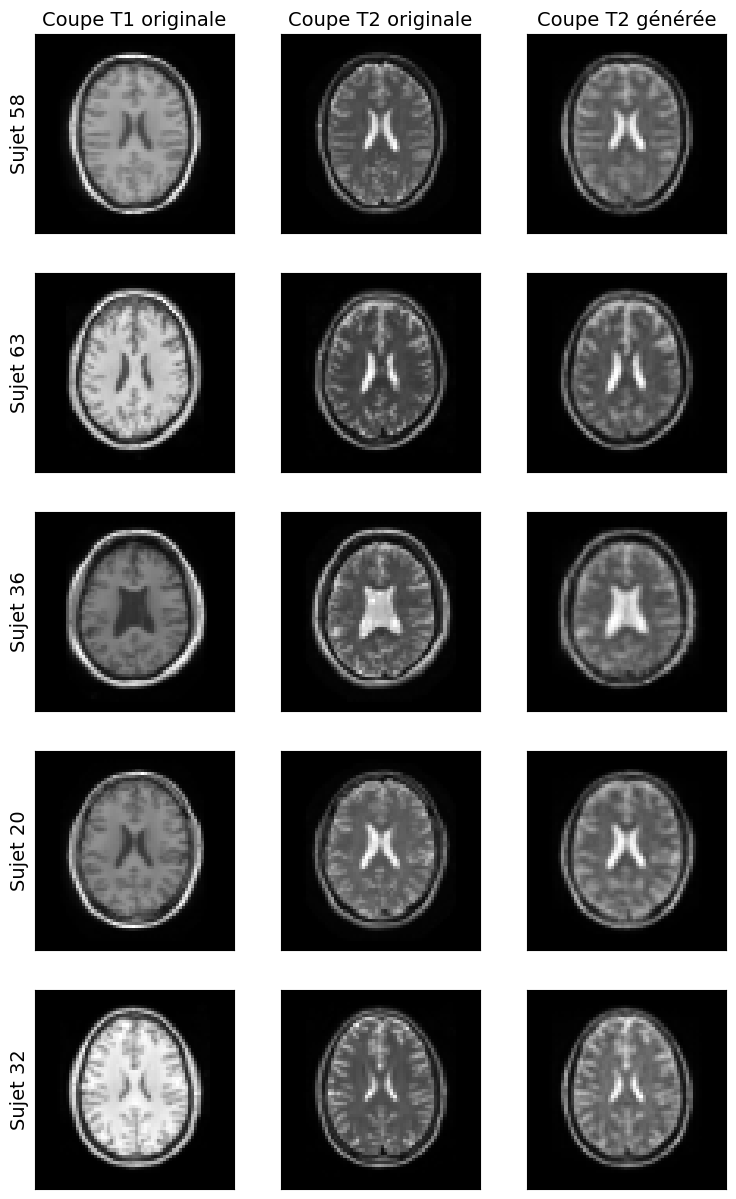

In [13]:
plot_generated_images(model_generator, dataset_val)

## Évaluation de la qualité des images

### Limites de l'erreur quadratique (ou absolue) moyenne

Les métriques pour comparer deux images qui effectuent une moyenne de comparaisons pixel par pixel, telles que l'erreur quadratique moyenne et l'erreur absolue moyenne, ne sont pas forcément les plus pertinentes par rapport à la perception visuelle humaine.
*Une image valant mille mots*, l'image ci-dessous illustre ce propos :

[<img src="../figures/comparaison_mse_ssim.png" width="750" />](../figures/comparaison_mse_ssim.png)

L'image originale se trouve en haut à gauche, et les cinq autres images sont des versions modifiées de cette image caractérisées par (quasiment) la même erreur quadratique moyenne ($144$ avec les valeurs des pixels allant de $0$ à $255$).
Pourtant, pour la perception humaine, certaines images modifiées sont bien plus proches de l'image originale que d'autres.

### Indice de mesure de similarité structurelle (*Structural Similarity Index Measure*)

Une autre métrique possible pour comparer deux images est l'**indice de mesure de similarité structurelle** (SSIM pour *Structural Similarity Index Measure*).
L'indice de mesure de similarité structurelle combine trois caractéristiques pour comparer deux images : la **luminosité**, le **contraste** et la **similarité structurelle**.

Ces caractéristiques se calculent à partir de métriques simples sur les deux images, telles que leur moyenne et leur écart-type.
On suppose que les valeurs des pixels ont été normalisées dans l'intervalle $[0, 1]$.
On utilise les notations suivantes :
* $x$ et $y$ sont deux images.
* $\mu$ correspond à la valeur moyenne des pixels : $\mu_x$ pour l'image $x$ et $\mu_y$ pour l'image $y$.
* $\sigma$ correspond à l'écart-type des pixels : $\sigma_x$ pour l'image $x$ et $\sigma_y$ pour l'image $y$.
* $\sigma_{xy}$ correspond à la covariance entre $x$ et $y$.

La **luminosité** correspond à la moyenne des pixels. Pour comparer les luminosités de deux images, on utilise la formule suivante :
$$
l(x, y) = \frac{2 \mu_x \mu_y + C_1}{\mu_x^2 + \mu_y^2 + C_1}
$$
où $C_1$ est une constante positive pour éviter une division par un nombre trop faible ($C_1 = 0.01$ par défaut).
Le score est bien positif (le numérateur et le dénominateur le sont), est inférieur ou égal à 1 et est égal à 1 si et seulement si les deux moyennes sont égales :
$$
(\mu_x - \mu_y)^2 \geq 0 \implies \mu_x^2 - 2 \mu_x \mu_y + \mu_y^2 \geq 0 \implies 2 \mu_x \mu_y \leq \mu_x^2 + \mu_y^2 \implies 2 \mu_x \mu_y + C_1 \leq \mu_x^2 + \mu_y^2 + C_1 
$$

Le **contraste**, qui est une mesure de la dispersion des pixels, correspond à l'écart-type des pixels. Pour comparer les contrastes de deux images, on utilise la même formule que pour la luminosité en remplaçant les moyennes par les écart-types :
$$
c(x, y) = \frac{2 \sigma_x \sigma_y + C_1}{\sigma_x^2 + \sigma_y^2 + C_2}
$$
où $C_2$ est une constante positive pour éviter une division par un nombre trop faible ($C_2 = 0.03$ par défaut).
Le score est bien positif (le numérateur et le dénominateur le sont), est inférieur ou égal à 1 et est égal à 1 si et seulement si les deux moyennes sont égales :
$$
(\sigma_x - \sigma_y)^2 \geq 0 \implies \sigma_x^2 - 2 \sigma_x \sigma_y + \sigma_y^2 \geq 0 \implies 2 \sigma_x \sigma_y \leq \sigma_x^2 + \sigma_y^2 \implies 2 \sigma_x \sigma_y + C_2 \leq \sigma_x^2 + \sigma_y^2 + C_2 
$$

La **similarité structurelle**, qui mesure la corrélation entre deux images, correspond au coefficient de corrélation entre les deux images :
$$
s(x, y) = \frac{\sigma_{xy} + C_3}{\sigma_x \sigma_y + C_3}
$$
où $C_3$ est une constante positive pour éviter une division par un nombre trop faible  ($C3=0.015$ par défaut).
Le score est compris entre $0$ et $1$ et vaut $1$ si et seulement si les deux images sont égales.

L'**indice de mesure de similarité structurelle** combine ces trois caractéristiques avec la formule suivante :
$$
\text{SSIM}(x, y) = \left[ l(x, y) \right]^\alpha \cdot \left[ c(x, y) \right]^\beta \cdot \left[ s(x, y) \right]^\gamma
$$
où les exposants $\alpha$, $\beta$ et $\gamma$ indiquent les poids des trois variables dans le score final.

Avec les valeurs par défaut ($\alpha = \beta = \gamma = 1$) et $C_3 = C_2 / 2$, on obtient la formule simplifiée suivante :
$$
\text{SSIM}(x, y) = \frac{(2 \mu_x \mu_y + C_1)(2 \sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}
$$

En revenant aux images ci-dessus, on voit bien que les images modifiées qui nous semblent davantage différentes de l'image originale ont des indices plus faibles.

## Réseau antagoniste génératif conditionnel (cGAN)

Un réseau antagoniste génératif (GAN pour *Generative Adversarial Network*) est une architecture composée de deux réseaux de neurones :
* Le **générateur** génère des observations synthétiques.
* Le **discriminateur** sépare les vraies observations des observations synthétiques.

Un réseau antagoniste génératif conditionnel (cGAN) est un réseau antagoniste génératif où le générateur et le discriminateur sont conditionnés :
* Le générateur ne doit pas seulement générer une observation synthétique réaliste, il doit en générer une en lien avec la condition.
* Le discriminateur ne doit pas seulement déterminer si l'observation est vraie ou synthétique, il doit également déterminer si l'observation est en lien avec la condition générée.
En effet, le générateur ne doit pas générer n'importe quelle image T2 à partir de l'image T1 (la condition) en entrée.
Il doit générer l'image T2 correspond à l'image T1 en entrée et non à n'importe quelle image T1.

Ayant déjà défini une classe pour l'architecture du générateur, il nous reste à définir le discriminateur.
L'image ci-dessous décrit l'architecture que l'on va utiliser pour le discriminateur :

[<img src="../figures/discriminator.png" width="750" />](../figures/discriminator.png)

### Question 5

La classe `Discriminator()` définie ci-dessous implémente cette architecutre.
L'architecture prend en entrée deux images et renvoie une probabilité.
Complétez le code manquant dans les méthodes `__init__()` et `forward()` de la classe `Discriminator()` en vous aidant de la méthode statique `discriminator_block()`.

> **Remarque** : Il manque sur l'image la couche d'aplatissement ([`torch.nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)) à la fin du discriminateur pour transformer l'image de taille $(1, 1, 1)$, c'est-à-dire un seul pixel avecun seul canal, en un vecteur de taille $(1,)$.

> **Remarque** : On a légèrement complexifié le code de la classe pour la rendre plus flexible. Avec cette implémentation, le discriminateur peut prendre en entrée soit une image (discriminateur non-conditionnel) soit deux images (discriminateur conditionnel) qui sont concaténées sur la dimension des canaux.

In [14]:
class Discriminator(L.LightningModule):
    """Classe pour le discriminateur.
    
    Parameters
    ----------
    in_channels : int (default = 1)
        Le nombre de canaux dans l'image en entrée.
        
    condition : bool (default = True)
        Indique si le discriminateur est conditionnel ou pas.
        Si True, le discriminateur est conditionnel et les deux
        images (l'entrée et la condition) sont concaténées le
        long de l'axe des canaux.
    """
    def __init__(self, in_channels=1, condition=True):
        super().__init__()

        self.condition = (condition is True)

        ### BEGIN TODO ###
        layers = []
        layers.extend(self.discriminator_block(in_channels * (1 + self.condition), 64))
        layers.extend(self.discriminator_block(64, 128))
        layers.extend(self.discriminator_block(128, 256))
        layers.extend(self.discriminator_block(256, 512))
        layers.append(torch.nn.Conv2d(512, 1, 4, padding=0))
        layers.append(torch.nn.Flatten())
        self.model = torch.nn.Sequential(*layers)
        #### END TODO ####

    def forward(self, T1, T2):
        if T2 is not None:
            assert self.condition
            dim = 1 if T1.ndim == 4 else 3
            T1 = torch.concat([T1, T2], dim=dim)
        else:
            assert not self.condition

        ### BEGIN TODO ###
        y = self.model(T1)
        if y.ndim == 2:
            y = torch.squeeze(y, dim=1)
        # y = 
        #### END TODO ####
        return y

    @staticmethod
    def discriminator_block(in_channels, out_channels):
        """Renvoie un bloc convolutif du discriminateur."""
        return [
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            torch.nn.LeakyReLU()
        ]

On affiche maintenant un résumé de l'architecture de de notre discriminateur :

In [15]:
summary(Discriminator(), input_size=[(32, 1, 64, 64), (32, 1, 64, 64)])

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [32]                      --
├─Sequential: 1-1                        [32, 1]                   --
│    └─Conv2d: 2-1                       [32, 64, 32, 32]          1,216
│    └─LeakyReLU: 2-2                    [32, 64, 32, 32]          --
│    └─Conv2d: 2-3                       [32, 128, 16, 16]         73,856
│    └─LeakyReLU: 2-4                    [32, 128, 16, 16]         --
│    └─Conv2d: 2-5                       [32, 256, 8, 8]           295,168
│    └─LeakyReLU: 2-6                    [32, 256, 8, 8]           --
│    └─Conv2d: 2-7                       [32, 512, 4, 4]           1,180,160
│    └─LeakyReLU: 2-8                    [32, 512, 4, 4]           --
│    └─Conv2d: 2-9                       [32, 1, 1, 1]             8,193
│    └─Flatten: 2-10                     [32, 1]                   --
Total params: 1,558,593
Trainable params: 1,558,593
Non-trainab

### Exercice 6

Maintenant que l'on a les classes pour le générateur et le discriminateur, on peut créer la classe implémentant notre réseau antagoniste génératif conditionnel.
La classe `CGAN()` définie ci-dessous implémente cette architecture de réseaux antagonistes génératifs conditionnels.
Complétez les méthodes `__init__()` et `forward()` de la classe `CGAN()` en utilisant les informations fournies dans le texte ci-dessous.

#### Architecture

On a déjà défini les classes pour le générateur et le discriminateur, il n'y a plus rien à faire à part initialiser ces deux réseaux de neurones.

#### Entraînement

On va entraîner en alternance le générateurs et les discriminateur, afin que l'un incite l'autre à s'améliorer :

* Concernant le **discriminateur**, il s'agit d'un problème classique de classification binaire. Un lot d'observations renvoie un lot de vraies images T1 et un lot de vraies images T2. On utilise le générateur pour obtenir les images T2 synthétiques. On effectue ensuite l'étape suivante :
    + On fournit en entrée du discriminateur les vraies images T1 et les vraies images T2, pour obtenir les logits que les vraies images T2 soient vraies. On fournit ces logits en entrée de la fonction de coût avec des labels positifs, soit $1$ (car les images T2 sont vraies ici).
    + On fournit en entrée du discriminateur les vraies images T1 et les images T2 synthétiques, pour obtenir les logits que les images synthétiques T2 soient vraies. On fournit ces logits en entrée de la fonction de coût avec des labels négatifs, soit $0$ (car les images T2 sont synthétiques ici). Pour stabiliser l'entraînement, **on utilise l'erreur quadratique moyenne (*a.k.a. MSE loss*) au lieu de l'entropie croisée binaire**.

* Concernant le **générateur**, la fonction de coût a deux composantes : celle correspondant à la différence entre l'image T2 synthétique et la vraie image T2, et celle correspondant à la duperie du discriminateur. Un lot d'observations renvoie un lot de vraies images T1 et un lot de vraies images T2. On utilise le générateur pour obtenir les images T2 synthétiques. Pour la première composante, on utilise l'erreur absolue moyenne (*a.k.a. L1 loss*) pour mesurer la différence entre l'image T2 synthétique et la vraie image T2. Pour la seconde composante, c'est également un problème de classification binaire. On fournit en entrée du discriminateur les vraies images T1 et les images T2 synthétiques, pour obtenir les logits que les images synthétiques T2 soient vraies. On fournit ces logits en entrée de la fonction de coût avec des labels positifs, soit $1$ (car on veut duper le discriminateur, c'est-à-dire qu'ils classent les images T2 synthétiques comme des vraies). On utilise à nouveau l'erreur quadratique moyenne comme fonction de coût.

#### Évaluation

Le principal critère d'évaluation reste la qualité des images synthétiques générées par le générateur.
On utilise à nouveau la similarité structurelle pour comparer les images synthétiques avec les vraies images.

In [16]:
class CGAN(L.LightningModule):
    """Classe implémentant notre réseau antagoniste génératif conditionnel (cGAN).

    Parameters
    ----------
    in_channels : int (default = 1)
        Nombre de canaux dans l'image en entrée.

    out_channels : int (default = 1)
        Nombre de canaux dans l'image renvoyée en sortie.

    lr : float (default = 1e-3)
        Taux d'apprentissage.

    betas : tuple[float, float] (default = (0.9, 0.999))
        Paramètres betas de l'algorithme d'optimisation Adam.
    """
    def __init__(self, in_channels=1, out_channels=1, lr=1e-3, betas=(0.9, 0.999)):
        super().__init__()

        self.lr = lr
        self.betas = betas

        ### BEGIN TODO ###
        # Initialisation des générateurs et des discriminateurs
        self.generator = Generator(in_channels, out_channels)
        self.discriminator = Discriminator(in_channels)

        # Initialisation des fonctions de perte
        self.classification_loss = torch.nn.MSELoss()
        self.reconstruction_loss = torch.nn.L1Loss()
        #### END TODO ####

        # Initialisation des métriques
        self.ssim_train = StructuralSimilarityIndexMeasure(data_range=(-1.0, 1.0))
        self.ssim_val = StructuralSimilarityIndexMeasure(data_range=(-1.0, 1.0))

        # Désactive l'optimisation automatique
        self.automatic_optimization = False
        
    def forward(self, x):
        return self.generator(x)
    
    def discriminator_step(self, T1, T2, dataset):
        """Effectue une étape pour le discriminateur.
        
        Parameters
        ----------
        T1 : Tensor
            Vraies images T1.
        
        T2 : Tensor
            Vraies images T2.
            
        dataset : {'training', 'validation'}
            Type d'étape (entraînement ou validation).
        
        Returns
        -------
        loss : torch.float32
            Fonction de coût.
        
        """
        ### BEGIN TODO ###
        # Génère des images T2 synthétiques à partir des vraies images T1
        T2_fake = self.generator(T1)
        
        # Calcule les logits des images T2 vraies et synthétiques sachant la vraie image T1
        logits_T2_real = self.discriminator(T2, T1)
        logits_T2_fake = self.discriminator(T2_fake, T1)
        
        # Génère les tenseurs pour les labels vrais (1) et synthétiques (0)
        batch_size = T1.size()[0] if T1.ndim == 4 else 1
        zeros = torch.zeros(batch_size).to(self.device)
        ones = torch.ones(batch_size).to(self.device)
        
        # Calcule la fonction de coût
        loss = (
            self.classification_loss(logits_T2_real, ones) + self.classification_loss(logits_T2_fake, zeros)
        )
        #### END TODO ####

        if dataset == "training":
            metric = self.ssim_train
            name = "train"
            bar_step = True
        else:
            metric = self.ssim_val
            name = "val"
            bar_step = False

        ssim = metric(T2_fake, T2)
        self.log(f"loss_discriminator_{name}", loss, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        self.log(f"ssim_discriminator_{name}", ssim, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        
        return loss

    def generator_step(self, T1, T2, dataset):
        """Effectue une étape pour les générateur.

        Parameters
        ----------
        T1 : Tensor
            Vraies images T1.

        T2 : Tensor
            Vraies images T2.

        dataset : {'training', 'validation'}
            Type d'étape (entraînement ou validation).

        Returns
        -------
        loss : torch.float32
            Fonction de coût.
        """
        ### BEGIN TODO ###
        # Génère des images T2 synthétiques à partir des vraies images T1
        T2_fake = self.generator(T1)
        
        # Calcule les logits des images T1 et T2 synthétiques
        logits_T2_real = self.discriminator(T2, T1)
        logits_T2_fake = self.discriminator(T2_fake, T1)
        
        # Génère les tenseurs pour les labels vrais (1)
        batch_size = T1.size()[0] if T1.ndim == 4 else 1
        ones = torch.ones(batch_size).to(self.device)
        
        # Calcule la fonction de coût
        loss = (
            self.classification_loss(logits_T2_fake, ones) + self.reconstruction_loss(T2_fake, T2)
        )
        #### END TODO ####

        if dataset == "training":
            metric = self.ssim_train
            name = "train"
            bar_step = True
        else:
            metric = self.ssim_val
            name = "val"
            bar_step = False

        ssim = metric(T2_fake, T2)
        self.log(f"loss_generator_{name}", loss, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        self.log(f"ssim_generator_{name}", ssim, prog_bar=bar_step, on_step=bar_step, on_epoch=True)

        return loss
    
    def training_step(self, batch):
        T1, T2 = batch
        optimizer_generator, optimizer_discriminator = self.optimizers()
        
        # Entraînement du générateur
        optimizer_generator.zero_grad()
        loss_generator = self.generator_step(T1, T2, "training")
        loss_generator.backward()
        optimizer_generator.step()

        # Entraînement du discriminateurs
        optimizer_discriminator.zero_grad()
        loss_discriminator = self.discriminator_step(T1, T2, "training")
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        return loss_generator + loss_discriminator
    
    def validation_step(self, batch):
        T1, T2 = batch
        
        with torch.no_grad():
            # Entraînement des générateurs
            loss_generator = self.generator_step(T1, T2, "validation")

            # Entraînement des discriminateurs
            loss_discriminator = self.discriminator_step(T1, T2, "validation")

        return loss_generator + loss_discriminator
        
    def on_train_start(self):
        """Code exécuté au début de l'entraînement."""
        string = f"Version {self.trainer.logger.version}"
        print(f"{string}\n{'=' * len(string)}\n")
    
    def on_train_epoch_end(self):
        """Code exécuté à la fin de chaque époque d'entraînement."""
        metrics = self.trainer.callback_metrics
        
        loss_gen_train = metrics["loss_generator_train"].item()
        loss_dis_train = metrics["loss_discriminator_train"].item()
        ssim_gen_train = metrics["ssim_generator_train"].item()
        ssim_dis_train = metrics["ssim_discriminator_train"].item()
        
        loss_gen_val = metrics["loss_generator_val"].item()
        loss_dis_val = metrics["loss_discriminator_val"].item()
        ssim_gen_val = metrics["ssim_generator_val"].item()
        ssim_dis_val = metrics["ssim_discriminator_val"].item()

        string = (f"""
            Époque {self.trainer.current_epoch + 1} / {self.trainer.max_epochs}
            -----------------------------------------------------------------
            |              Jeu               | Fonction de perte |   SSIM   |
            | ------------------------------ | ----------------- | -------- |
            |   Entraînement (générateurs)   |{loss_gen_train:^19.5f}|{ssim_gen_train:^10.6f}|
            | Entraînement (discriminateurs) |{loss_dis_train:^19.5f}|{ssim_dis_train:^10.6f}|
            |    Validation (générateurs)    |{loss_gen_val:^19.5f}|{ssim_gen_val:^10.6f}|
            |  Validation (discriminateurs)  |{loss_dis_val:^19.5f}|{ssim_dis_val:^10.6f}|
            -----------------------------------------------------------------
        """)
        string = '\n'.join([line.strip() for line in string.strip().split('\n')])
        print(string, "\n")
    
    def configure_optimizers(self):
        """Configure les algorithmes d'optimisation à utiliser."""
        optimizer_generator = torch.optim.Adam(
            self.generator.parameters(), lr=self.lr, betas=self.betas
        )

        optimizer_discriminator = torch.optim.Adam(
            self.discriminator.parameters(), lr=self.lr, betas=self.betas
        )
        return [optimizer_generator, optimizer_discriminator]

On entraîne maintenant notre cGAN pendant $20$ époques.
Notez que, par rapport au générateur seul, **on utilise un taux d'apprentissage plus faible**.
Cela est nécessaire pour que le discriminateur ne devienne pas bien meilleur que le générateur, ce qui empêcherait le générateur de devenir meilleur (c'est notre objectif principal, le discriminateur n'est qu'un outil pour aider le générateur).

In [17]:
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger


model_cgan = CGAN(lr=1e-4)

trainer_cgan = L.Trainer(
    max_epochs=20,
    enable_model_summary=False,  # supprimer le résumé du modèle
    logger=CSVLogger('.'),  # sauvegarder les résultats dans un fichier CSV
    num_sanity_val_steps=0,  # ne pas effectuer d'étape de validation avant l'entraînement
    log_every_n_steps=10,
    callbacks=[TQDMProgressBar(refresh_rate=5)]  # mettre à jour la barre de progression tous les 10 lots
)

trainer_cgan.fit(
    model=model_cgan,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

Training: |                                               | 0/? [00:00<?, ?it/s]

Version 1



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 1 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.76696      | 0.249078 |
| Entraînement (discriminateurs) |      0.56577      | 0.283827 |
|    Validation (générateurs)    |      0.55191      | 0.522437 |
|  Validation (discriminateurs)  |      0.48776      | 0.522437 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 2 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.40126      | 0.589367 |
| Entraînement (discriminateurs) |      0.49116      | 0.598660 |
|    Validation (générateurs)    |      0.40510      | 0.648553 |
|  Validation (discriminateurs)  |      0.49018      | 0.648553 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 3 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.34981      | 0.679727 |
| Entraînement (discriminateurs) |      0.49150      | 0.683278 |
|    Validation (générateurs)    |      0.34936      | 0.698484 |
|  Validation (discriminateurs)  |      0.49486      | 0.698484 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 4 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.33440      | 0.699640 |
| Entraînement (discriminateurs) |      0.49862      | 0.699821 |
|    Validation (générateurs)    |      0.32917      | 0.698627 |
|  Validation (discriminateurs)  |      0.49645      | 0.698627 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 5 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.33358      | 0.697910 |
| Entraînement (discriminateurs) |      0.49819      | 0.697829 |
|    Validation (générateurs)    |      0.33676      | 0.692908 |
|  Validation (discriminateurs)  |      0.49480      | 0.692908 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 6 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.33528      | 0.696735 |
| Entraînement (discriminateurs) |      0.49224      | 0.697601 |
|    Validation (générateurs)    |      0.33859      | 0.701364 |
|  Validation (discriminateurs)  |      0.49041      | 0.701364 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 7 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.33614      | 0.689423 |
| Entraînement (discriminateurs) |      0.50218      | 0.687405 |
|    Validation (générateurs)    |      0.34671      | 0.668146 |
|  Validation (discriminateurs)  |      0.49520      | 0.668146 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 8 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.34383      | 0.661158 |
| Entraînement (discriminateurs) |      0.50377      | 0.659257 |
|    Validation (générateurs)    |      0.35204      | 0.635133 |
|  Validation (discriminateurs)  |      0.49694      | 0.635133 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 9 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.34861      | 0.649197 |
| Entraînement (discriminateurs) |      0.50250      | 0.650659 |
|    Validation (générateurs)    |      0.34531      | 0.655180 |
|  Validation (discriminateurs)  |      0.49694      | 0.655180 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 10 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.34546      | 0.645416 |
| Entraînement (discriminateurs) |      0.51206      | 0.644659 |
|    Validation (générateurs)    |      0.35547      | 0.646473 |
|  Validation (discriminateurs)  |      0.49904      | 0.646473 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 11 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.33990      | 0.672555 |
| Entraînement (discriminateurs) |      0.50146      | 0.676054 |
|    Validation (générateurs)    |      0.32685      | 0.691039 |
|  Validation (discriminateurs)  |      0.50142      | 0.691039 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 12 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.33344      | 0.689305 |
| Entraînement (discriminateurs) |      0.50506      | 0.688787 |
|    Validation (générateurs)    |      0.34650      | 0.682299 |
|  Validation (discriminateurs)  |      0.49845      | 0.682299 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 13 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.33710      | 0.683391 |
| Entraînement (discriminateurs) |      0.50182      | 0.683356 |
|    Validation (générateurs)    |      0.34780      | 0.683051 |
|  Validation (discriminateurs)  |      0.49515      | 0.683051 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 14 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.33847      | 0.679297 |
| Entraînement (discriminateurs) |      0.50787      | 0.677629 |
|    Validation (générateurs)    |      0.32796      | 0.653745 |
|  Validation (discriminateurs)  |      0.50751      | 0.653745 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 15 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.33731      | 0.676667 |
| Entraînement (discriminateurs) |      0.49815      | 0.679876 |
|    Validation (générateurs)    |      0.32544      | 0.699126 |
|  Validation (discriminateurs)  |      0.48878      | 0.699126 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 16 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.33509      | 0.694708 |
| Entraînement (discriminateurs) |      0.50573      | 0.693205 |
|    Validation (générateurs)    |      0.32868      | 0.678537 |
|  Validation (discriminateurs)  |      0.50555      | 0.678537 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 17 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.34617      | 0.661261 |
| Entraînement (discriminateurs) |      0.50392      | 0.659028 |
|    Validation (générateurs)    |      0.35352      | 0.642524 |
|  Validation (discriminateurs)  |      0.49249      | 0.642524 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 18 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.34482      | 0.642314 |
| Entraînement (discriminateurs) |      0.50954      | 0.641789 |
|    Validation (générateurs)    |      0.35077      | 0.638911 |
|  Validation (discriminateurs)  |      0.49589      | 0.638911 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 19 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.34632      | 0.674229 |
| Entraînement (discriminateurs) |      0.48715      | 0.679046 |
|    Validation (générateurs)    |      0.34958      | 0.705611 |
|  Validation (discriminateurs)  |      0.49169      | 0.705611 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 20 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.33709      | 0.692366 |
| Entraînement (discriminateurs) |      0.51920      | 0.689451 |
|    Validation (générateurs)    |      0.35119      | 0.659404 |
|  Validation (discriminateurs)  |      0.50908      | 0.659404 |
-----------------------------------------------------------------



### Exercice 7

Visualizez quelques images générées par le générateur du cGAN grâce à la fonction `plot_generated_images()` définie plus haut.
Comparez les performances du générateur du cGAN avec le générateur et expliquez la différence.
Suggérez des pistes d'amélioration.

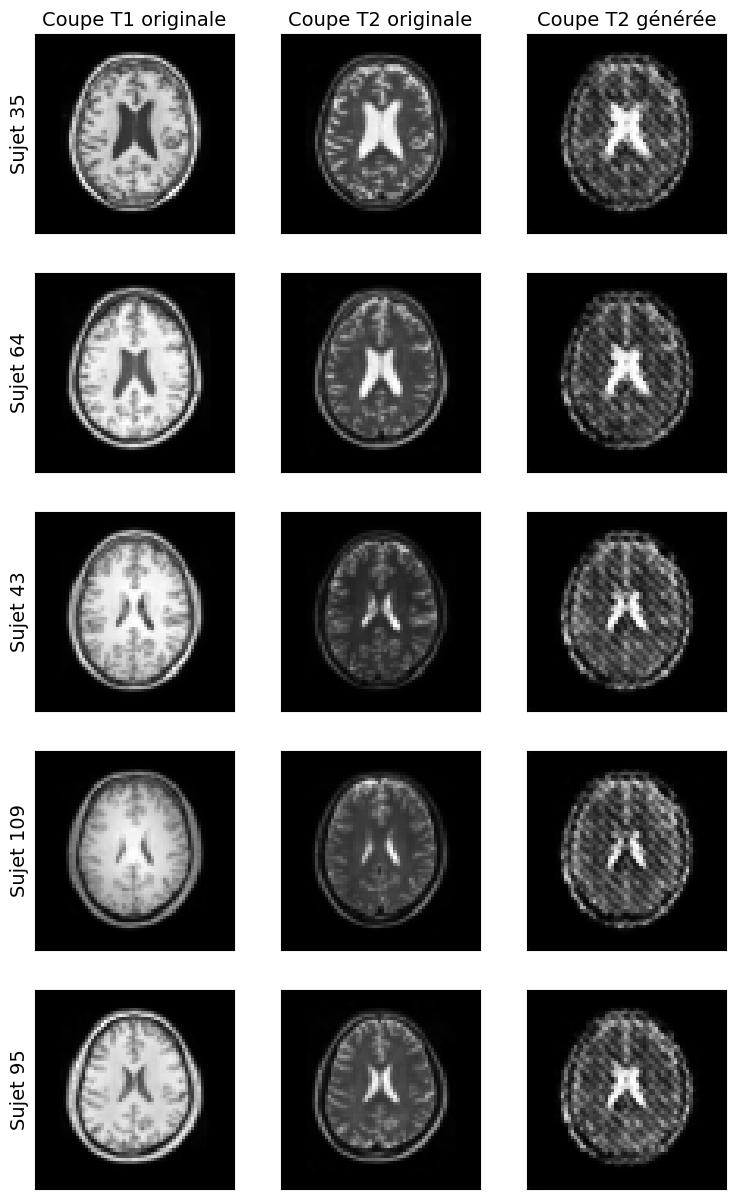

In [18]:
plot_generated_images(model_cgan, dataset_val)

**Réponse** : On a du baisser le taux d'apprentissage pour le cGAN afin de s'assurer que le discriminateur ne devienne pas bien meilleur que le générateur. Il faut donc plus d'itérations (et donc d'époques) pour obtenir un niveau de performance donné pour le générateur. Une solution possible serait d'augmenter le nombre d'époques, mais cela prendrait encore plus de temps à entraîner le modèle. Une autre solution possible serait de modifier les poids des deux composantes de la fonction de coût du générateur pour davantage pondérer l'erreur de reconstruction et moins l'erreur de classification.

## CycleGAN

Un réseau antagoniste génératif cyclique (CycleGAN) est un modèle de traduction d'images **non supervisée**.
Cette approche se base sur deux réseaux antagonistes génératifs et est entraîné sur des **données non-appariées**.
On ne va donc plus utiliser cette propriété de notre jeu de données et faire comme si les données étaient non-appariées.

La traduction d'images est une méthode générative **conditionnelle**.
On ne veut pas obtenir n'importe quelle image en sortie, mais une image en lien avec l'image fournie en entrée.
Quand on a accès à des données appartiées, c'est-à-dire l'image originale et sa traduction, on peut entraîner un modèle génératif conditionnel comme on l'a fait dans la première partie de ce notebook.
Néanmoins, cette approche est impossible si on n'a pas accès à des données appariées, ce qui est souvent le cas.

Pour contrer ce problème, l'innovation principale des *CycleGAN* est d'utiliser **deux réseaux antagonistes génératifs** (GAN) et d'introduire le concept de **cohérence des cycles** : si on génère une image synthétique dans le domaine *Y* à partir d'une image originale dans le domaine *X*, puis si on génère une image synthétique dans le domaine *X* à partir de l'image synthétique dans le domaine *Y*, alors les deux images dans le domaine *X* (l'image originale et l'image générée) doivent être très proches.
En effet, si l'image générée dans le domaine *Y* ne contient pas les caractéristiques de l'image originale, alors il sera impossible d'avoir une image générée dans le domaine *X*, générée à partir de l'image générée dans le domaine *Y*, proche de l'image originale.

L'image ci-dessous résume les principaux concepts d'un CycleGAN :

[<img src="../figures/cycle_consistency.png" width="750" />](../figures/cycle_consistency.png)

### Exercice 8

La classe `CycleGAN()` définie ci-dessous implémente cette architecture de réseaux antagonistes génératifs cycliques.
Complétez les méthodes `__init__()`, `discriminators_step()` et `generators_step()` de la classe `CycleGAN()` en utilisant les informations fournies dans le texte ci-dessous.

#### Architecture

Les deux réseaux ont la même architecture, à savoir :

* Pour les générateurs, on utilise l'architecture déjà définie dans la classe `Generator()`.

* Pour les discriminateurs, on utilise l'architecture définie dans le classe `Discriminator()`.

#### Entraînement

On va entraîner en alternance les générateurs et les discriminateurs, afin que les uns incitent les autres à s'améliorer :

* Concernant les **discriminateurs**, il s'agit de deux problèmes classiques de classification binaire. Un lot d'observations renvoie un lot de vraies images T1 et un lot de vraies images T2. On va également utiliser les deux générateurs pour obtenir un lot d'images T1 synthétiques et un lot d'images T2 synthétiques. On va fournir les images T1 vraies et synthétiques en entrée du discriminateur T1 pour obtenir ses prédictions (passe avant), évaluer la fonction de perte pour calculer les gradients (passe arrière) pour mettre à jour les valeurs des paramètres entraînables du discriminateur T1. On effectue de même pour le discriminateur T2. Cependant, on va utiliser une autre fonction de perte que l'entropie croisée. En effet, une technique pour stabiliser l'entraînement et générer de meilleures images est de **remplacer l'entropie croisée par l'erreur quadratique moyenne** (*a.k.a. MSE loss*).

* Concernant les **générateurs**, l'entraînement est un peu plus complexe. On a tout d'abord la partie qui consiste à tromper les discriminateurs, c'est-à-dire le même problème de classification binaire que pour les discriminateurs mais avec les labels inversés : les labels doivent être *vrais* pour les images générées et *générées* pour les vraies images. Enfin, il faut rajouter les termes pour la cohérence des cycles : on utilisera l'erreur absolue moyenne (*a.k.a. L1 loss*) entre la vraie image et l'image synthétique (dans le même domaine).

#### Évaluation

Le principal critère d'évaluation reste la qualité des images synthétiques générées par le générateur du domaine $T1$ vers le domaine $T2$.
On utilise à nouveau la similarité structurelle pour comparer les images synthétiques avec les vraies images.

In [19]:
import itertools


class CycleGAN(L.LightningModule):
    def __init__(self, in_channels=1, out_channels=1, lr=1e-3, betas=(0.9, 0.999)):
        super().__init__()
        
        self.lr = lr
        self.betas = betas
        
        ### BEGIN TODO ###
        # Initialisation des générateurs et des discriminateurs
        self.generator_from_t1_to_t2 = Generator(in_channels, out_channels)
        self.generator_from_t2_to_t1 = Generator(in_channels, out_channels)
        self.discriminator_t1 = Discriminator(in_channels, condition=False)
        self.discriminator_t2 = Discriminator(in_channels, condition=False)
        
        # Initialisation des fonctions de perte
        self.classification_loss = torch.nn.MSELoss()
        self.l1_loss = torch.nn.L1Loss()
        #### END TODO ####

        # Initialisation des métriques
        self.ssim_train = StructuralSimilarityIndexMeasure(data_range=(-1.0, 1.0))
        self.ssim_val = StructuralSimilarityIndexMeasure(data_range=(-1.0, 1.0))
        
        # Désactive l'optimisation automatique
        self.automatic_optimization = False

    def forward(self, x):
        return self.generator_from_t1_to_t2(x)
        
    def discriminators_step(self, T1, T2, dataset):
        """Effectue une étape pour les discriminateurs.
        
        Parameters
        ----------
        T1 : Tensor
            Vraies images T1.
        
        T2 : Tensor
            Vraies images T2.
            
        dataset : {'training', 'validation'}
            Type d'étape (entraînement ou validation).
        
        Returns
        -------
        loss : torch.float32
            Fonction de coût.
        
        """
        ### BEGIN TODO ###
        # Génère des images T1 et T2 synthétiques à partir des vraies images T1 et T2 
        T2_fake = self.generator_from_t1_to_t2(T2)
        T1_fake = self.generator_from_t2_to_t1(T2)
        
        # Calcule les logits des images T1 et T2 vraies et synthétiques
        logits_T1_real = self.discriminator_t1(T1, None)
        logits_T1_fake = self.discriminator_t1(T1_fake, None)
        logits_T2_real = self.discriminator_t2(T2, None)
        logits_T2_fake = self.discriminator_t2(T2_fake, None)
        
        # Génère les tenseurs pour les labels vrais (1) et synthétiques (0)
        batch_size = T1.size()[0] if T1.ndim == 4 else 1
        zeros = torch.zeros(batch_size).to(self.device)
        ones = torch.ones(batch_size).to(self.device)
        
        # Calcule la fonction de coût
        loss = (
            self.classification_loss(logits_T1_real, ones) + self.classification_loss(logits_T1_fake, zeros) +
            self.classification_loss(logits_T2_real, ones) + self.classification_loss(logits_T2_fake, zeros)
        )
        #### END TODO ####

        if dataset == 'training':
            metric = self.ssim_train
            name = 'train'
            bar_step = True
        else:
            metric = self.ssim_val
            name = 'val'
            bar_step = False

        ssim = metric(T2_fake, T2)
        self.log(f"loss_discriminators_{name}", loss, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        self.log(f"ssim_discriminators_{name}", ssim, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        
        return loss

    def generators_step(self, T1, T2, dataset):
        """Effectue une étape pour les générateurs.
        
        Parameters
        ----------
        T1 : Tensor
            Vraies images T1.
        
        T2 : Tensor
            Vraies images T2.
            
        dataset : {'training', 'validation'}
            Type d'étape (entraînement ou validation).
        
        Returns
        -------
        loss : torch.float32
            Fonction de coût.
        
        """
        ### BEGIN TODO ###
        # Génère des images T1 et T2 synthétiques à partir des vraies images T1 et T2 
        T2_fake = self.generator_from_t1_to_t2(T1)
        T1_fake = self.generator_from_t2_to_t1(T2)
        
        # Génère des images T1 et T2 synthétiques à partir des images synthétiques T1 et T2
        T1_fake_fake = self.generator_from_t2_to_t1(T2_fake)
        T2_fake_fake = self.generator_from_t1_to_t2(T1_fake)
        
        # Calcule les logits des images T1 et T2 synthétiques
        logits_T1_fake = self.discriminator_t1(T1_fake, None)
        logits_T2_fake = self.discriminator_t2(T2_fake, None)
        
        # Génère les tenseurs pour les labels vrais (1)
        batch_size = T1.size()[0] if T1.ndim == 4 else 1
        ones = torch.ones(batch_size).to(self.device)
        
        # Calcule la fonction de coût
        loss = (
            self.classification_loss(logits_T1_fake, ones) + self.classification_loss(logits_T2_fake, ones) +
            self.l1_loss(T1, T1_fake_fake) + self.l1_loss(T2, T2_fake_fake)
        )
        #### END TODO ####

        if dataset == "training":
            metric = self.ssim_train
            name = "train"
            bar_step = True
        else:
            metric = self.ssim_val
            name = "val"
            bar_step = False

        ssim = metric(T2_fake, T2)
        self.log(f"loss_generators_{name}", loss, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        self.log(f"ssim_generators_{name}", ssim, prog_bar=bar_step, on_step=bar_step, on_epoch=True)

        return loss

    def training_step(self, batch):
        T1, T2 = batch
        optimizer_generators, optimizer_discriminators = self.optimizers()
        
        # Entraînement des générateurs
        optimizer_generators.zero_grad()
        loss_generators = self.generators_step(T1, T2, "training")
        loss_generators.backward()
        optimizer_generators.step()

        # Entraînement des discriminateurs
        optimizer_discriminators.zero_grad()
        loss_discriminators = self.discriminators_step(T1, T2, "training")
        loss_discriminators.backward()
        optimizer_discriminators.step()
        
        return loss_generators + loss_discriminators
    
    def validation_step(self, batch):
        T1, T2 = batch
        
        with torch.no_grad():
            # Entraînement des générateurs
            loss_generators = self.generators_step(T1, T2, "validation")

            # Entraînement des discriminateurs
            loss_discriminators = self.discriminators_step(T1, T2, "validation")

        return loss_generators + loss_discriminators
        
    def on_train_start(self):
        """Code exécuté au début de l'entraînement."""
        string = f"Version {self.trainer.logger.version}"
        print(f"{string}\n{'=' * len(string)}\n")
    
    def on_train_epoch_end(self):
        """Code exécuté à la fin de chaque époque d'entraînement."""
        metrics = self.trainer.callback_metrics
        
        loss_gen_train = metrics["loss_generators_train"].item()
        loss_dis_train = metrics["loss_discriminators_train"].item()
        ssim_gen_train = metrics["ssim_generators_train"].item()
        ssim_dis_train = metrics["ssim_discriminators_train"].item()
        
        loss_gen_val = metrics["loss_generators_val"].item()
        loss_dis_val = metrics["loss_discriminators_val"].item()
        ssim_gen_val = metrics["ssim_generators_val"].item()
        ssim_dis_val = metrics["ssim_discriminators_val"].item()

        string = (f"""
            Époque {self.trainer.current_epoch + 1} / {self.trainer.max_epochs}
            -----------------------------------------------------------------
            |              Jeu               | Fonction de perte |   SSIM   |
            | ------------------------------ | ----------------- | -------- |
            |   Entraînement (générateurs)   |{loss_gen_train:^19.5f}|{ssim_gen_train:^10.6f}|
            | Entraînement (discriminateurs) |{loss_dis_train:^19.5f}|{ssim_dis_train:^10.6f}|
            |    Validation (générateurs)    |{loss_gen_val:^19.5f}|{ssim_gen_val:^10.6f}|
            |  Validation (discriminateurs)  |{loss_dis_val:^19.5f}|{ssim_dis_val:^10.6f}|
            -----------------------------------------------------------------
        """)
        string = '\n'.join([line.strip() for line in string.strip().split('\n')])
        print(string, "\n")

    def configure_optimizers(self):
        """Configure les algorithmes d'optimisation à utiliser."""
        optimizer_generators = torch.optim.Adam(itertools.chain(
            self.generator_from_t1_to_t2.parameters(), self.generator_from_t2_to_t1.parameters()
        ), lr=self.lr, betas=self.betas)

        optimizer_discriminators = torch.optim.Adam(itertools.chain(
            self.discriminator_t1.parameters(), self.discriminator_t2.parameters()
        ), lr=self.lr, betas=self.betas)

        return [optimizer_generators, optimizer_discriminators]

On va maintenant entraîner notre modèle pendant $20$ époques.
Pour les mêmes raisons que pour le cGAN, **on utilise un taux d'apprentissage plus faible**.

In [20]:
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger


model_cyclegan = CycleGAN(lr=1e-4)

trainer_cyclegan = L.Trainer(
    max_epochs=20,
    enable_model_summary=False,  # supprimer le résumé du modèle
    logger=CSVLogger('.'),  # sauvegarder les résultats dans un fichier CSV
    num_sanity_val_steps=0,  # ne pas effectuer d'étape de validation avant l'entraînement
    log_every_n_steps=10,
)

trainer_cyclegan.fit(
    model=model_cyclegan,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

Training: |                                               | 0/? [00:00<?, ?it/s]

Version 2



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 1 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      1.66774      | 0.153001 |
| Entraînement (discriminateurs) |      1.12839      | 0.170768 |
|    Validation (générateurs)    |      1.03014      | 0.339659 |
|  Validation (discriminateurs)  |      0.89339      | 0.339659 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 2 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.94904      | 0.457295 |
| Entraînement (discriminateurs) |      0.96816      | 0.471188 |
|    Validation (générateurs)    |      0.76399      | 0.536547 |
|  Validation (discriminateurs)  |      0.94845      | 0.536547 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 3 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.79300      | 0.572149 |
| Entraînement (discriminateurs) |      1.01282      | 0.574871 |
|    Validation (générateurs)    |      0.75092      | 0.573017 |
|  Validation (discriminateurs)  |      1.02673      | 0.573017 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 4 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.75649      | 0.583061 |
| Entraînement (discriminateurs) |      1.04077      | 0.583280 |
|    Validation (générateurs)    |      0.76999      | 0.575819 |
|  Validation (discriminateurs)  |      1.00259      | 0.575819 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 5 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.75704      | 0.587956 |
| Entraînement (discriminateurs) |      1.01820      | 0.590087 |
|    Validation (générateurs)    |      0.74637      | 0.602422 |
|  Validation (discriminateurs)  |      1.01371      | 0.602422 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 6 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.74652      | 0.599217 |
| Entraînement (discriminateurs) |      1.02751      | 0.598329 |
|    Validation (générateurs)    |      0.75331      | 0.590349 |
|  Validation (discriminateurs)  |      0.98779      | 0.590349 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 7 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.74710      | 0.588448 |
| Entraînement (discriminateurs) |      1.00980      | 0.588892 |
|    Validation (générateurs)    |      0.74550      | 0.596042 |
|  Validation (discriminateurs)  |      0.99639      | 0.596042 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 8 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.74567      | 0.612695 |
| Entraînement (discriminateurs) |      1.03744      | 0.615088 |
|    Validation (générateurs)    |      0.74873      | 0.630765 |
|  Validation (discriminateurs)  |      1.01622      | 0.630765 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 9 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.74959      | 0.626899 |
| Entraînement (discriminateurs) |      1.02020      | 0.626274 |
|    Validation (générateurs)    |      0.78235      | 0.615251 |
|  Validation (discriminateurs)  |      0.98128      | 0.615251 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 10 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.75739      | 0.587870 |
| Entraînement (discriminateurs) |      1.02835      | 0.582822 |
|    Validation (générateurs)    |      0.74365      | 0.543383 |
|  Validation (discriminateurs)  |      1.02910      | 0.543383 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 11 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.73656      | 0.605976 |
| Entraînement (discriminateurs) |      1.02254      | 0.613499 |
|    Validation (générateurs)    |      0.73863      | 0.653356 |
|  Validation (discriminateurs)  |      0.98641      | 0.653356 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 12 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.73474      | 0.659344 |
| Entraînement (discriminateurs) |      1.02985      | 0.658925 |
|    Validation (générateurs)    |      0.73909      | 0.648402 |
|  Validation (discriminateurs)  |      1.02852      | 0.648402 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 13 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.75643      | 0.631555 |
| Entraînement (discriminateurs) |      1.01668      | 0.630555 |
|    Validation (générateurs)    |      0.78249      | 0.633087 |
|  Validation (discriminateurs)  |      0.99592      | 0.633087 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 14 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.75967      | 0.635404 |
| Entraînement (discriminateurs) |      1.03229      | 0.631656 |
|    Validation (générateurs)    |      0.76995      | 0.572558 |
|  Validation (discriminateurs)  |      1.04426      | 0.572558 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 15 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.76394      | 0.570255 |
| Entraînement (discriminateurs) |      1.00776      | 0.571656 |
|    Validation (générateurs)    |      0.76460      | 0.592057 |
|  Validation (discriminateurs)  |      1.00200      | 0.592057 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 16 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.76106      | 0.622746 |
| Entraînement (discriminateurs) |      0.98160      | 0.627388 |
|    Validation (générateurs)    |      0.76735      | 0.664180 |
|  Validation (discriminateurs)  |      0.93208      | 0.664180 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 17 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.75711      | 0.674045 |
| Entraînement (discriminateurs) |      1.06009      | 0.672537 |
|    Validation (générateurs)    |      0.83293      | 0.646229 |
|  Validation (discriminateurs)  |      1.07461      | 0.646229 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 18 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.84391      | 0.649949 |
| Entraînement (discriminateurs) |      0.93210      | 0.651021 |
|    Validation (générateurs)    |      0.94309      | 0.655441 |
|  Validation (discriminateurs)  |      0.84122      | 0.655441 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 19 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      0.93253      | 0.581443 |
| Entraînement (discriminateurs) |      1.00404      | 0.573207 |
|    Validation (générateurs)    |      0.90230      | 0.531015 |
|  Validation (discriminateurs)  |      0.81518      | 0.531015 |
-----------------------------------------------------------------



Validation: |                                             | 0/? [00:00<?, ?it/s]


Époque 20 / 20
-----------------------------------------------------------------
|              Jeu               | Fonction de perte |   SSIM   |
| ------------------------------ | ----------------- | -------- |
|   Entraînement (générateurs)   |      1.11783      | 0.589638 |
| Entraînement (discriminateurs) |      1.03578      | 0.596025 |
|    Validation (générateurs)    |      0.94362      | 0.621955 |
|  Validation (discriminateurs)  |      0.89197      | 0.621955 |
-----------------------------------------------------------------



### Exercice 9

Visualizez quelques images générées par le générateur du CycleGAN grâce à la fonction `plot_generated_images()` définie plus haut.
Comparez les performances du générateur du cGAN avec le générateur et expliquez la différence.
Suggérez des pistes d'amélioration.

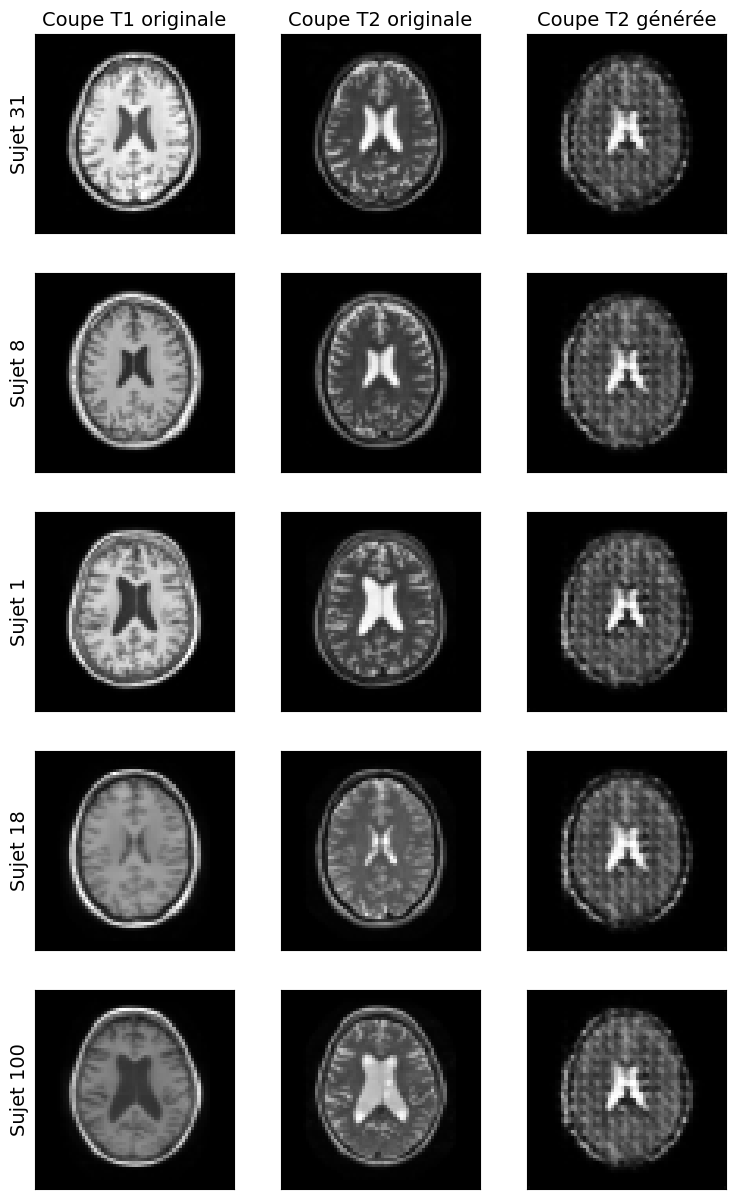

In [21]:
plot_generated_images(model_cyclegan, dataset_val)

**Réponse** : Étant donné qu'on n'utilise plus le fait que les données sont appariées, l'entraînement est encore plus difficile, et on n'obtient pas la même performance qu'avec un seul générateur au bout de $20$ époques. Une approche possible serait bien sûr d'augmenter le nombre d'époques parce qu'on n'est pas sûr que le modèle est convergé. Une autre approche serait d'utiliser davantage de données d'entraînement. En effet, en pratique, on devrait avoir beaucoup plus de données disponibles si on ne requiert pas qu'elles soient appariées.